In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import glob
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall
from asreviewcontrib.insights.plot import _recall_values
from asreviewcontrib.insights.utils import pad_simulation_labels
import shutil
from asreview import ASReviewProject
from asreview import ASReviewData
from langdetect import detect
import pylab

# Dataset descriptives

In [2]:
data_descriptives = pd.read_csv("./output/tables/data_descriptives.csv")
data_descriptives.head()

,Unnamed: 0,n_records,n_relevant,n_irrelevant,n_unlabeled,n_missing_title,n_missing_abstract,n_duplicates
0,data_stats_Hamilton_English.json,1859,87,1772,0,5,305,9
1,data_stats_Hamilton_Multi_1.json,1859,87,1772,0,5,305,9
2,data_stats_Hamilton_Multi_2.json,1859,87,1772,0,5,305,9
3,data_stats_Hamilton_Original.json,1859,87,1772,0,5,305,9


## Dataset performance

In [3]:
data_metrics = pd.read_csv("./output/tables/data_metrics.csv")
data_metrics

,Unnamed: 0,file_name,recall_0.1,recall_0.25,recall_0.5,recall_0.75,recall_0.9,wss_0.95,erf_0.1,atd
0,0,metrics_sim_Hamilton_English_svm_distiluse_0.json,0.651163,0.883721,0.976744,1.000000,1.000000,0.615509,0.546512,196.976744
1,1,metrics_sim_Hamilton_English_svm_mpnet_0.json,0.604651,0.906977,0.976744,1.000000,1.000000,0.649435,0.500000,205.441860
2,2,metrics_sim_Hamilton_English_svm_stsb_0.json,0.651163,0.906977,1.000000,1.000000,1.000000,0.652666,0.546512,189.011628
3,3,metrics_sim_Hamilton_English_svm_tfidf_0.json,0.755814,0.930233,0.976744,1.000000,1.000000,0.665590,0.651163,145.755814
4,4,metrics_sim_Hamilton_Multi_1_svm_distiluse_0.json,0.639535,0.930233,1.000000,1.000000,1.000000,0.661282,0.534884,175.686047
5,5,metrics_sim_Hamilton_Multi_1_svm_mpnet_0.json,0.593023,0.883721,0.976744,0.988372,0.988372,0.592353,0.488372,217.883721
6,6,metrics_sim_Hamilton_Multi_1_svm_stsb_0.json,0.546512,0.906977,1.000000,1.000000,1.000000,0.616586,0.441860,215.023256
7,7,metrics_sim_Hamilton_Multi_1_svm_tfidf_0.json,0.755814,0.883721,0.941860,0.953488,0.988372,0.461497,0.651163,209.279070
8,8,metrics_sim_Hamilton_Multi_2_svm_distiluse_0.json,0.627907,0.895349,0.988372,1.000000,1.000000,0.609047,0.523256,201.034884
9,9,metrics_sim_Hamilton_Multi_2_svm_mpnet_0.json,0.639535,0.883721,0.976744,0.988372,1.000000,0.580506,0.534884,221.918605


## Retrieve all target tds

In [4]:
file = "./output/simulation/Hamilton_{}/metrics/metrics_sim_Hamilton_{}_svm_{}_0.json"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'stsb', 'distiluse', 'mpnet']

values = []
for dataset in datasets:
    for model in models:
        with open(file.format(dataset, dataset, model)) as f:
            i = next(filter(lambda x: x['id'] == 'td', json.load(f)['data']['items']))['value']
            values.extend([dataset] + [model] + value for value in i)
df = pd.DataFrame(values, columns=['dataset', 'model', 'record_id', 'td'])
targets = df.loc[df.record_id.isin([300, 567, 741, 878, 1112])]
targets

,dataset,model,record_id,td
75,Original,tfidf,741,361
77,Original,tfidf,878,406
81,Original,tfidf,567,782
82,Original,tfidf,300,785
84,Original,tfidf,1112,826
...,...,...,...,...
1323,Multi_2,mpnet,741,104
1357,Multi_2,mpnet,878,271
1372,Multi_2,mpnet,1112,715
1373,Multi_2,mpnet,567,806


## Plot per dataset

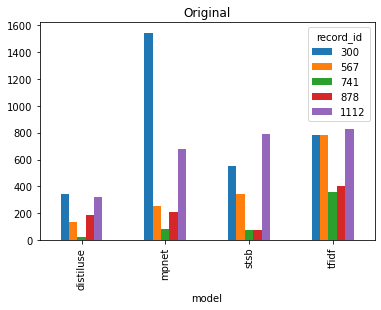

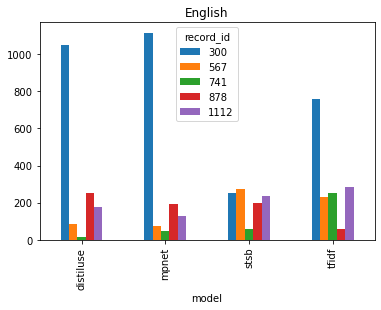

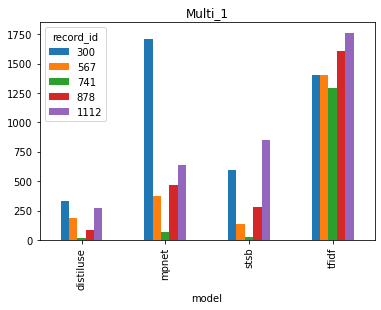

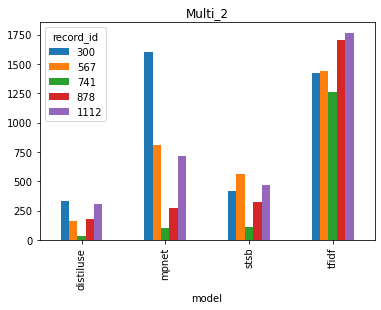

In [7]:
for dataset in datasets:
    pivot = pd.pivot_table(targets.loc[targets.dataset == dataset], 
                              values="td", 
                              index="model", 
                              columns="record_id")
    pivot.plot.bar(title=dataset)

## Plot per model

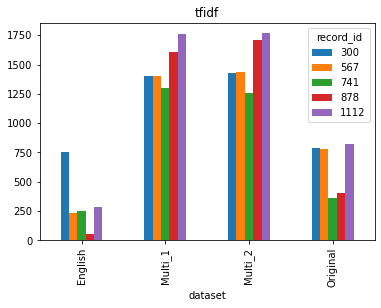

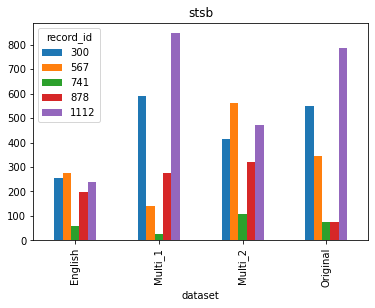

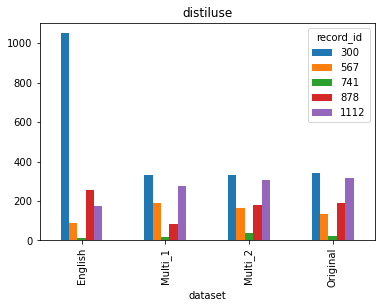

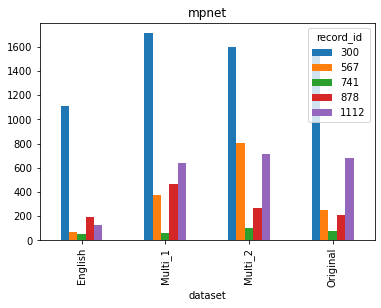

In [8]:
for model in models:
    pivot = pd.pivot_table(targets.loc[targets.model == model], 
                              values="td", 
                              index="dataset", 
                              columns="record_id")
    pivot.plot.bar(title=model)

## Recall plots

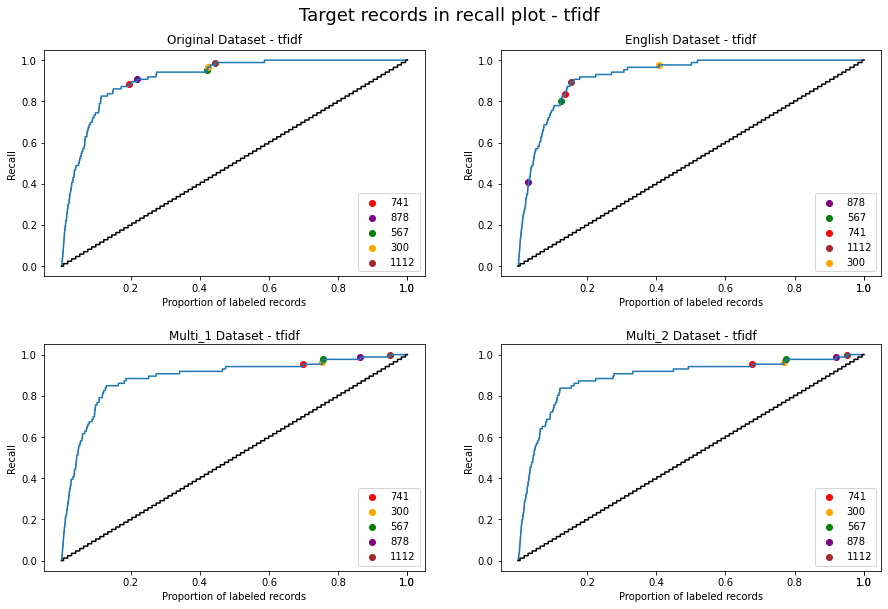

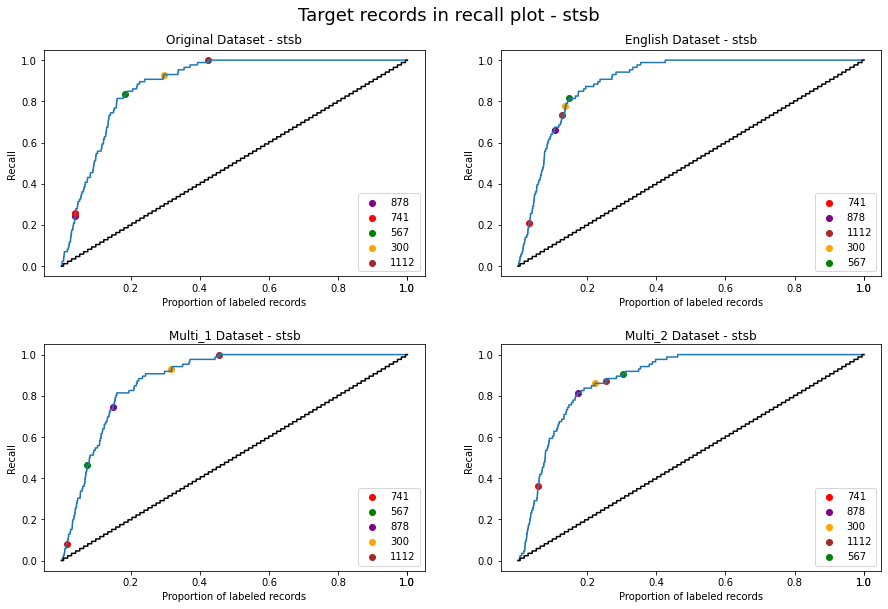

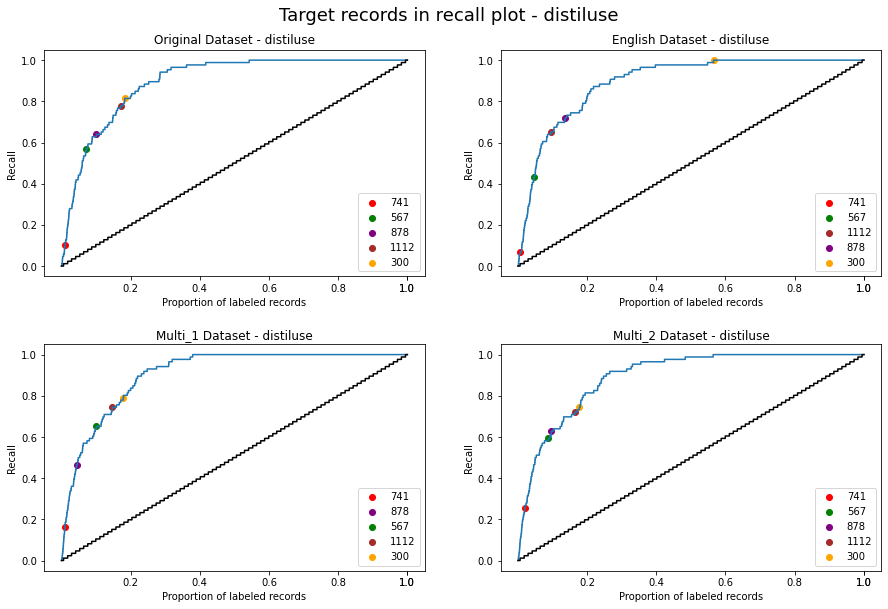

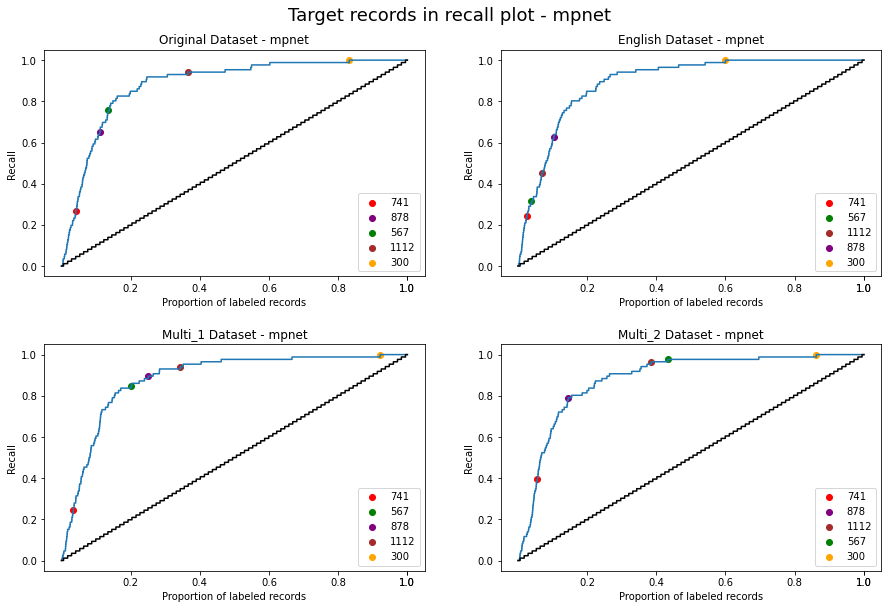

In [9]:
labels = []
colors = list(mcolors.TABLEAU_COLORS.values())
colors = {300:'orange', 567:'green', 741:'red', 878:'purple', 1112:'brown'}

file = "./output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_svm_{}_0"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'stsb', 'distiluse', 'mpnet']

for model in models:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle("Target records in recall plot - "+model, fontsize=18, y=0.92)
    n=0
    for dataset in datasets:
        state_file = file.format(dataset, dataset, model)+'.asreview'
        with open_state(state_file) as state:

            ax = plt.subplot(3, 2, n + 1)

            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            increasing = [i for i,v in enumerate(y) if i and v > y[i-1]]
            if y[0] > 0:
                increasing.insert(0, 0)

            positions = df.loc[(df.dataset==dataset) & (df.model==model)].reset_index()
            positions = positions.loc[positions.record_id.isin([300, 567, 741, 878, 1112])]

            record_ids = []
            color=1
            for index, row in positions.iterrows():
                ax.scatter(x[increasing[index]], y[increasing[index]], marker="o", c=colors[row.record_id])
                record_ids.append(row.record_id)
                color+=1
            ax.legend(record_ids)

            #draw the plot
            plot_recall(ax, state)

            metadata = state.settings_metadata
            label = " - ".join(
                    [metadata["settings"]["model"],
                     metadata["settings"]["feature_extraction"],
                     metadata["settings"]["balance_strategy"],
                     metadata["settings"]["query_strategy"]])    
            if label not in labels:
                ax.lines[-2].set_label(label)
                labels.append(label)
            ax.set_title(dataset + " Dataset - " + model)
            n+=1

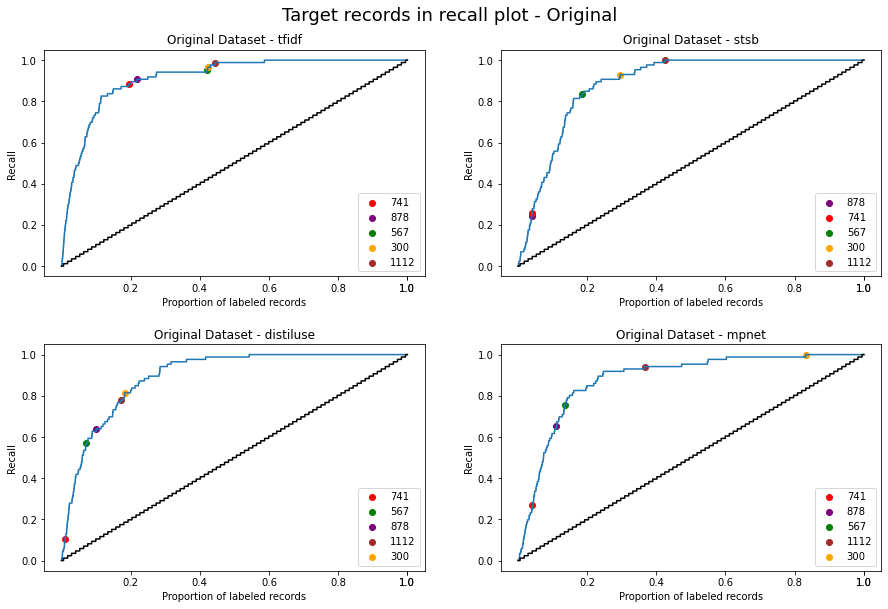

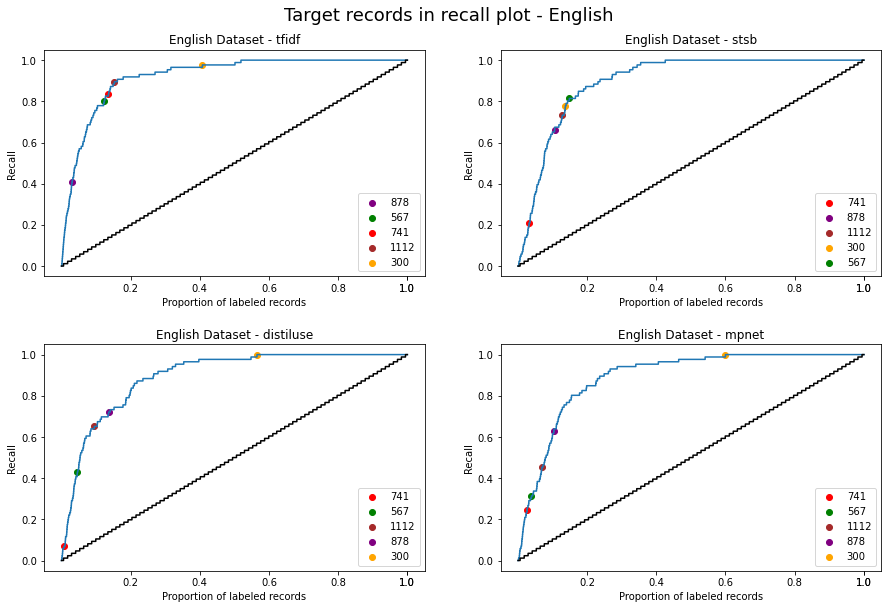

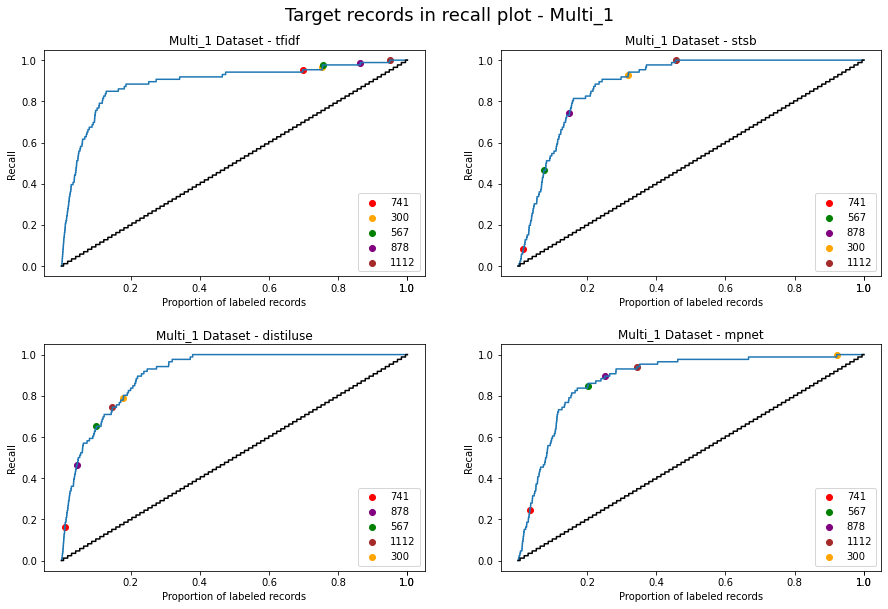

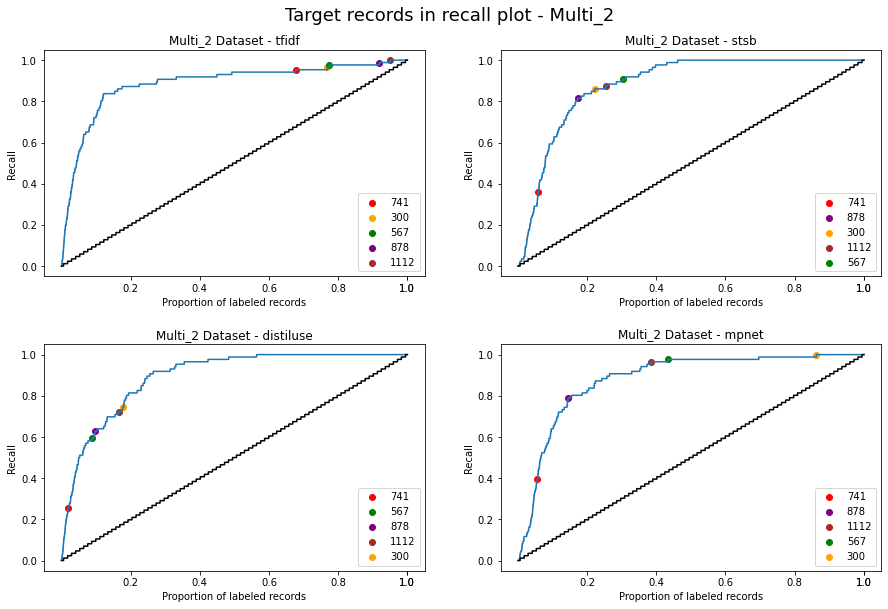

In [27]:
labels = []
colors = list(mcolors.TABLEAU_COLORS.values())
#colors = {300:'orange', 567:'green', 741:'red', 878:'purple', 1112:'brown'}

file = "./output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_svm_{}_0.asreview"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'stsb', 'distiluse', 'mpnet']

for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle("Target records in recall plot - "+dataset, fontsize=18, y=0.92)
    n=0
    for model in models:
        state_file = file.format(dataset, dataset, model)
        with open_state(state_file) as state:

            ax = plt.subplot(3, 2, n + 1)

            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            increasing = [i for i,v in enumerate(y) if i and v > y[i-1]]
            if y[0] > 0:
                increasing.insert(0, 0)

            positions = df.loc[(df.dataset==dataset) & (df.model==model)].reset_index()
            positions = positions.loc[positions.record_id.isin([300, 567, 741, 878, 1112])]

            record_ids = []
            color=1
            for index, row in positions.iterrows():
                ax.scatter(x[increasing[index]], y[increasing[index]], marker="o", c=colors[row.record_id])
                record_ids.append(row.record_id)
                color+=1
            ax.legend(record_ids)

            #draw the plot
            plot_recall(ax, state)

            metadata = state.settings_metadata
            label = " - ".join(
                    [metadata["settings"]["model"],
                     metadata["settings"]["feature_extraction"],
                     metadata["settings"]["balance_strategy"],
                     metadata["settings"]["query_strategy"]])    
            if label not in labels:
                ax.lines[-2].set_label(label)
                labels.append(label)
            ax.set_title(dataset + " Dataset - " + model)
            n+=1

In [2]:
state_file = "./output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_svm_{}_0.asreview"
csv_file = "./data/Hamilton_{}.csv"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'stsb', 'distiluse', 'mpnet', 'minilm', 'labse', 'mlongt5']

In [3]:
language_dfs = {}
for dataset in datasets:
    file = csv_file.format(dataset)
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

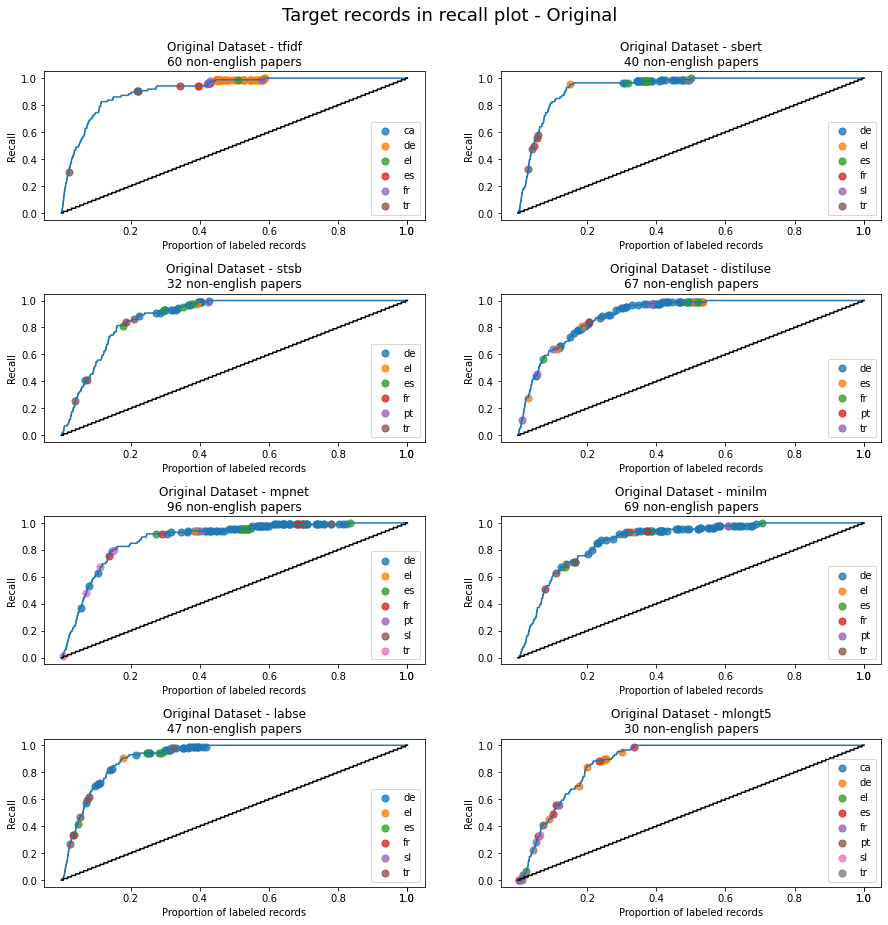

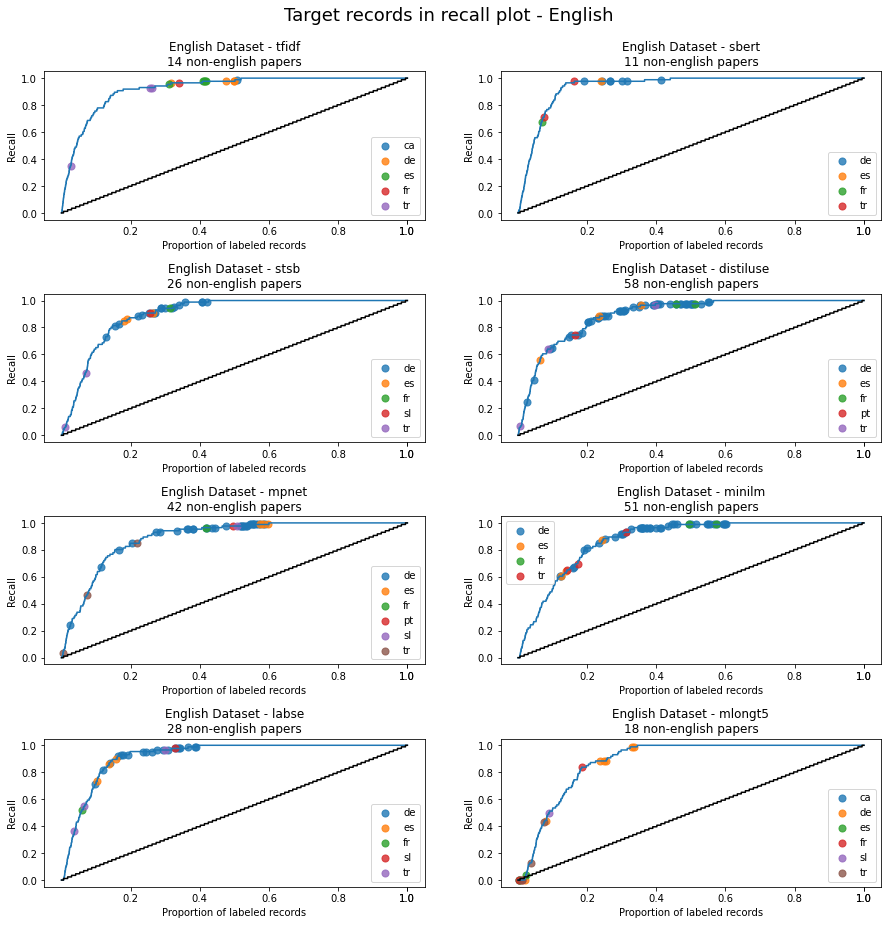

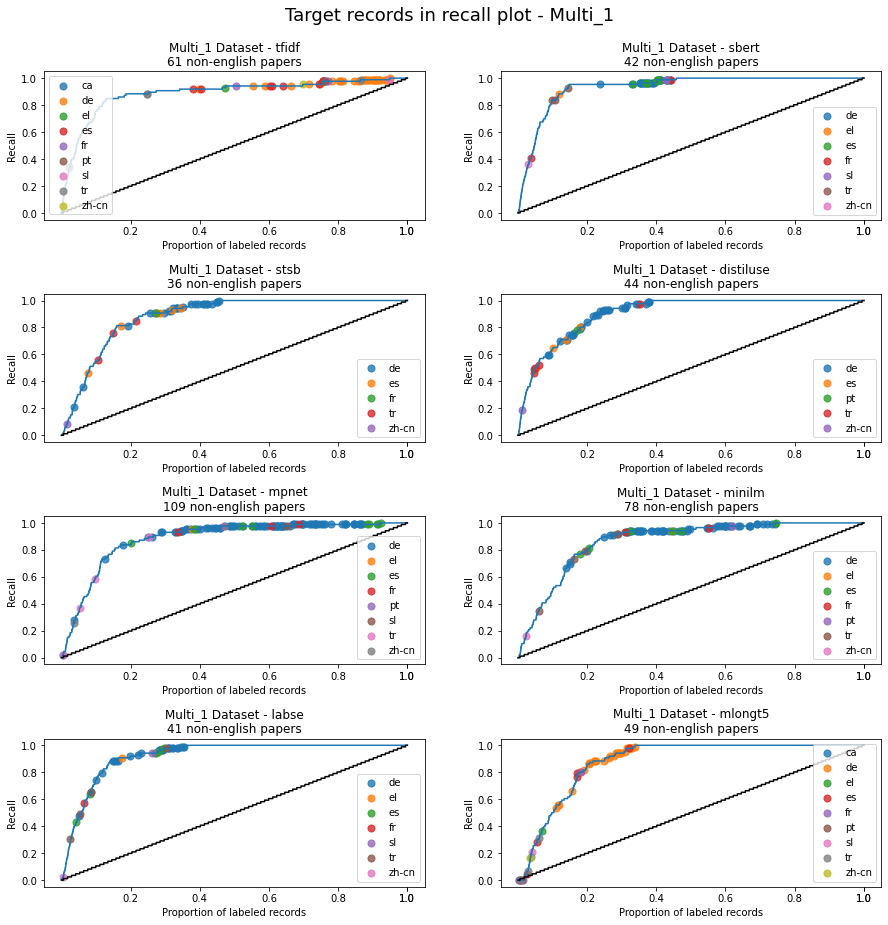

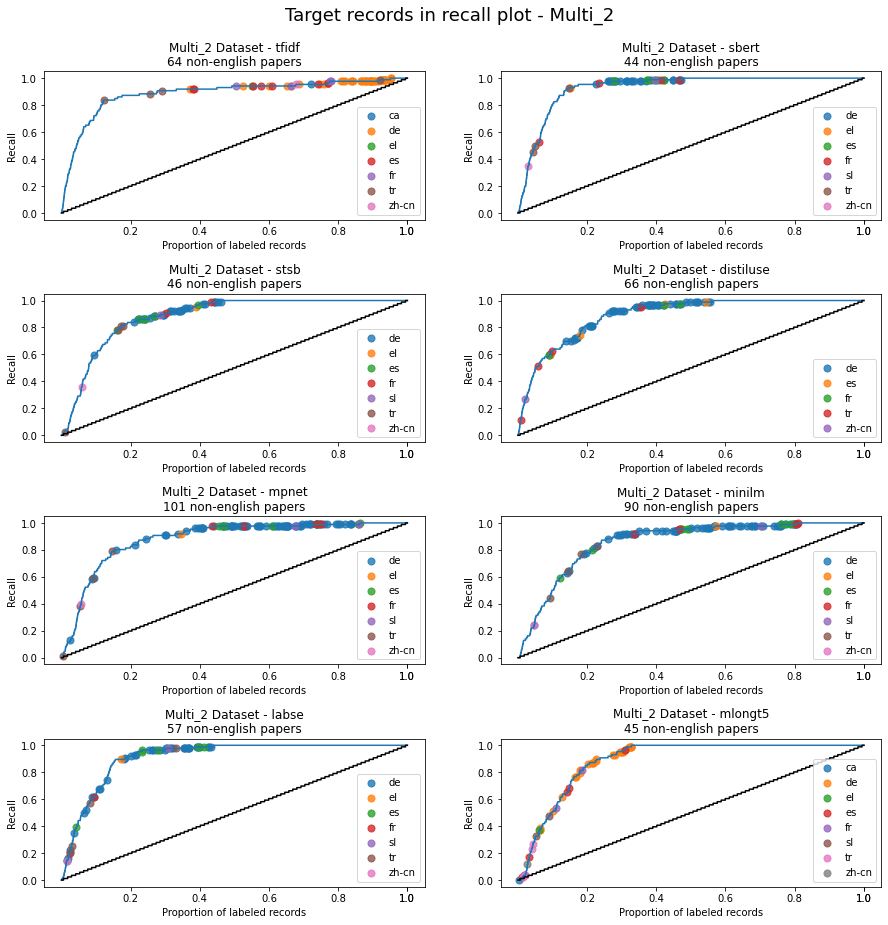

In [5]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 2, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False))]
            
            #print(non_english.language.head().sort_values().unique())
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", alpha=0.8, s=50)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)
 
            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1

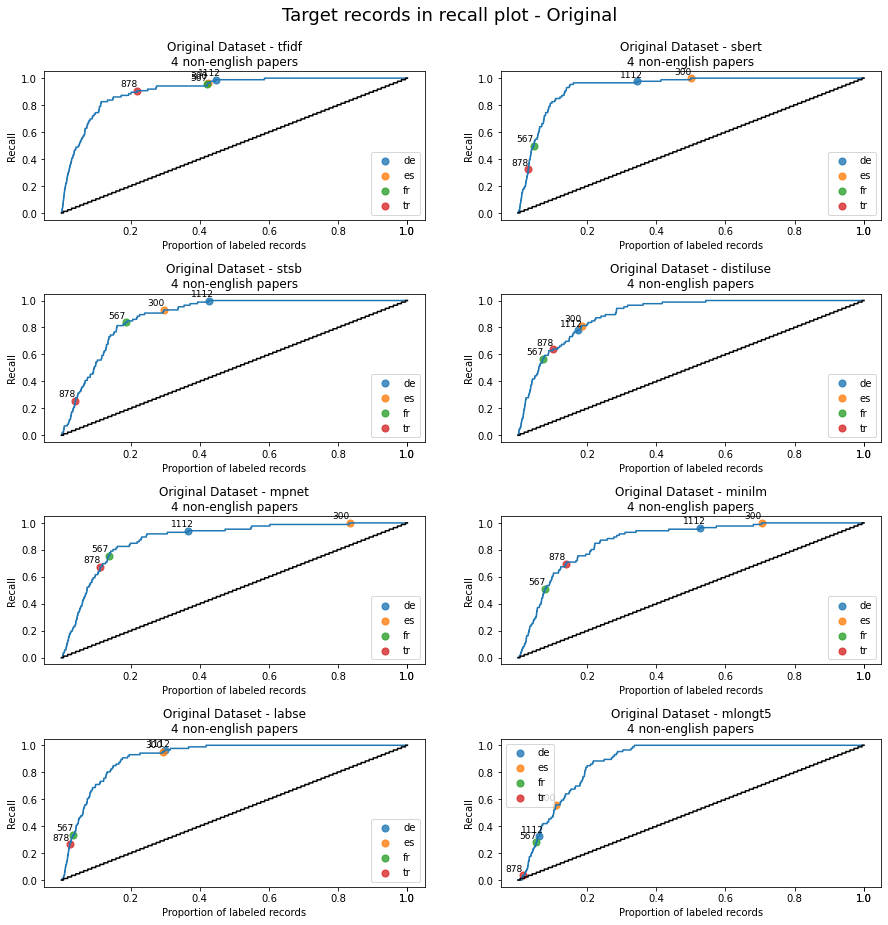

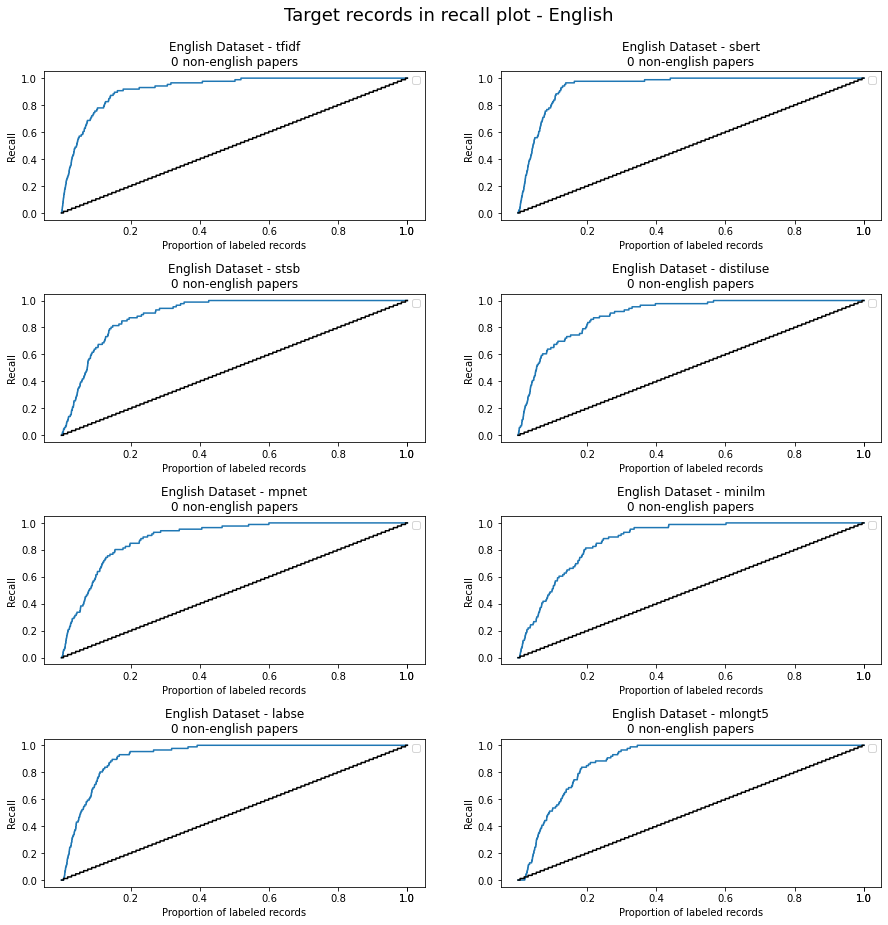

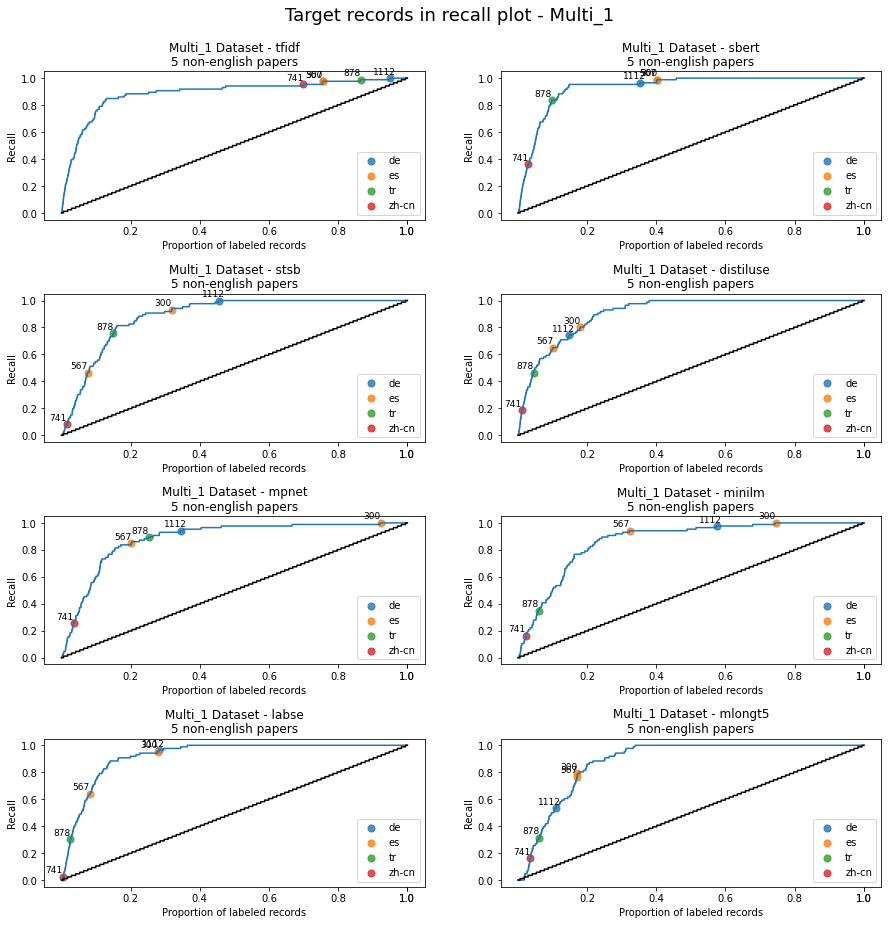

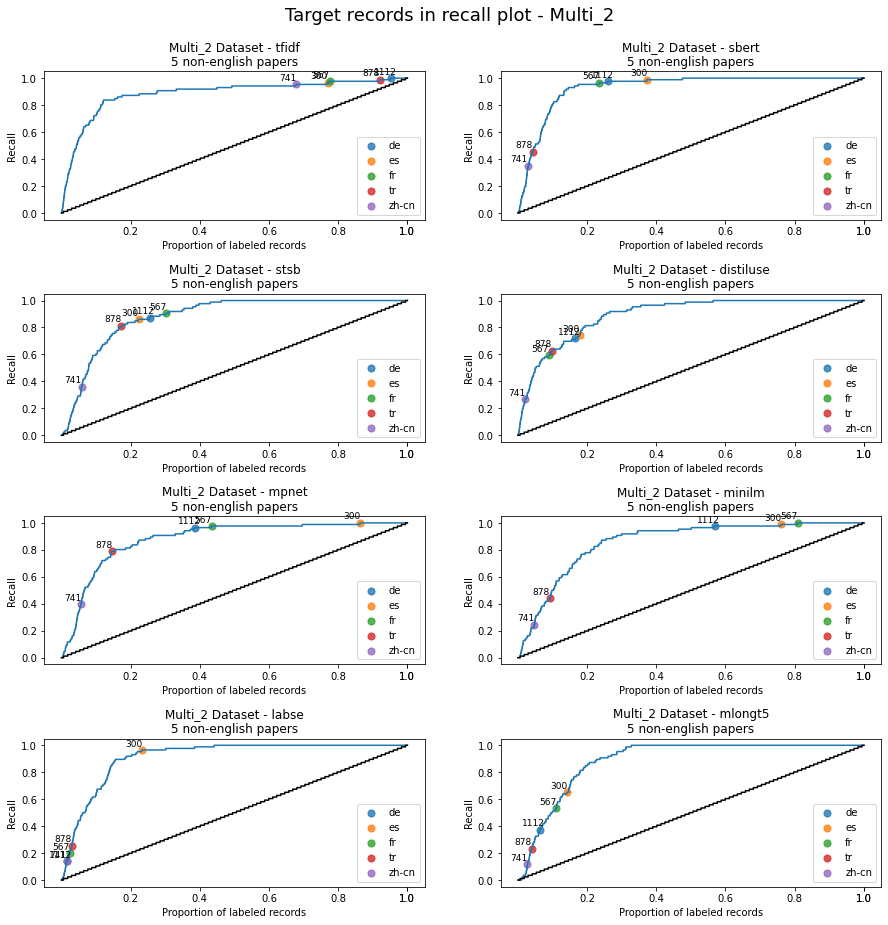

In [6]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.94)
    n=0
    for model in models:
        ax = plt.subplot(4, 2, n + 1)
        with open_state(state_file.format(dataset, dataset, model)) as state:
            states_df = state.get_dataset()
            
            sim_labels = pad_simulation_labels(state)
            x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)
            
            languages = language_dfs[dataset]
            states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
            non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                        & (states_df.label == 1))]
            
            for language in non_english.language.sort_values().unique():
                temp = non_english.loc[non_english.language==language]
                ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50, alpha=0.8)
                for index, row in temp.iterrows():
                    ax.text(x[index]-0.05, y[index]+0.03, row.record_id, fontsize=9)
            ax.legend(non_english.language.sort_values().unique())
            
            #draw the plot
            plot_recall(ax, state)

            ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
            n+=1